In [381]:
import matplotlib
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

#Read in the csv. Throw out bad lines-- there are just a few of the 9000-- and suppress warnings.
filepath = "./emerald_equity_hpd_violations.csv"
df = pd.read_csv(filepath, error_bad_lines=False, warn_bad_lines=False)
#Wrap text, because I want to see those commplaints in their entirety
pd.set_option('display.max_colwidth', -1)

filepath2 = "./emerald_equity_dob_complaints.csv"
df_dob = pd.read_csv(filepath2)
'''CREATE TABLE emerald_equity_dob_complaints AS
SELECT complaintcategory, status, complaintnumber, inspectiondate, housenumber, housestreet
FROM dob_complaints
JOIN emerald_equity_bin_bbl
ON dob_complaints.bin = emerald_equity_bin_bbl.bin;'''

#This is for all of East Harlem
df_dob_harlem = pd.read_csv('east_harlem_dob_complaints.csv', low_memory=False)

df_recent = pd.read_csv("./emerald_equity_dob_complaints1.csv")
'''CREATE TABLE recent_emerald_equity_dob_complaints AS select complaintcategory, status, complaintnumber, inspectiondate, housenumber, housestreet
FROM dob_complaints
JOIN emerald_equity_bin_bbl
ON dob_complaints.bin = emerald_equity_bin_bbl.bin
WHERE dobrundate > '2017-01-01';'''

df_historical = pd.read_csv("./emerald_equity_dob_complaints_historical.csv")
'''CREATE TABLE recent_emerald_equity_dob_complaints AS select complaintcategory, status, complaintnumber, inspectiondate, housenumber, housestreet
FROM dob_complaints
JOIN emerald_equity_bin_bbl
ON dob_complaints.bin = emerald_equity_bin_bbl.bin
WHERE dobrundate > '2015-08-30' AND dobrundate < '2017-01-01';'''

df_hpdnonrecent = pd.read_csv("./nonrecent_hpd_violations.csv")
df_hpdrecent = pd.read_csv("./recent_hpd_violations.csv")



harlem_hpd_df = pd.read_csv("./hpd_harlem.csv")
ee_hpd_df = pd.read_csv("./hpd_emerald_equity.csv")

In [382]:
df_dob.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)

In [383]:
#These are the things I want to pay attention to
df_hpdrecent['Mold'] = df_hpdrecent['novdescription'].str.contains('MOLD').astype(int)
df_hpdrecent['Gas'] = df_hpdrecent['novdescription'].str.contains('GAS').astype(int)
df_hpdrecent['Heat'] = df_hpdrecent['novdescription'].str.contains('HEAT').astype(int)
df_hpdrecent['Pests'] = df_hpdrecent['novdescription'].str.contains('PEST|RODENT|ROACH|MICE').astype(int)
df_hpdrecent['Scalding_Water'] = df_hpdrecent['novdescription'].str.contains('SCALDING').astype(int)
df_hpdrecent['Lead'] = df_hpdrecent['novdescription'].str.contains('LEAD').astype(int)
df_hpdrecent['Bedbugs'] = df_hpdrecent['novdescription'].str.contains('BEDBUGS').astype(int)


#set index as bbl
df_hpdrecent.set_index('bbl', inplace=True)

#These are the things I want to pay attention to
df_hpdnonrecent['Mold'] = df_hpdnonrecent['novdescription'].str.contains('MOLD').astype(int)
df_hpdnonrecent['Gas'] = df_hpdnonrecent['novdescription'].str.contains('GAS').astype(int)
df_hpdnonrecent['Heat'] = df_hpdnonrecent['novdescription'].str.contains('HEAT').astype(int)
df_hpdnonrecent['Pests'] = df_hpdnonrecent['novdescription'].str.contains('PEST|RODENT|ROACH|MICE|BEDBUGS').astype(int)
df_hpdnonrecent['Scalding_Water'] = df_hpdnonrecent['novdescription'].str.contains('SCALDING').astype(int)
df_hpdnonrecent['Lead'] = df_hpdnonrecent['novdescription'].str.contains('LEAD').astype(int)
df_hpdnonrecent['Bedbugs'] = df_hpdnonrecent['novdescription'].str.contains('BEDBUGS').astype(int)
#set index as bbl
df_hpdnonrecent.set_index('bbl', inplace=True)

In [384]:
# Sum up all the counts of instances of violations, grouping by bbl (building)
# Then, concatenate them

df_hpdnonrecent = df_hpdnonrecent.groupby(df_hpdnonrecent.index).sum()
df_hpdrecent = df_hpdrecent.groupby(df_hpdrecent.index).sum()
df = pd.concat([df_hpdrecent, df_hpdnonrecent], axis=1)

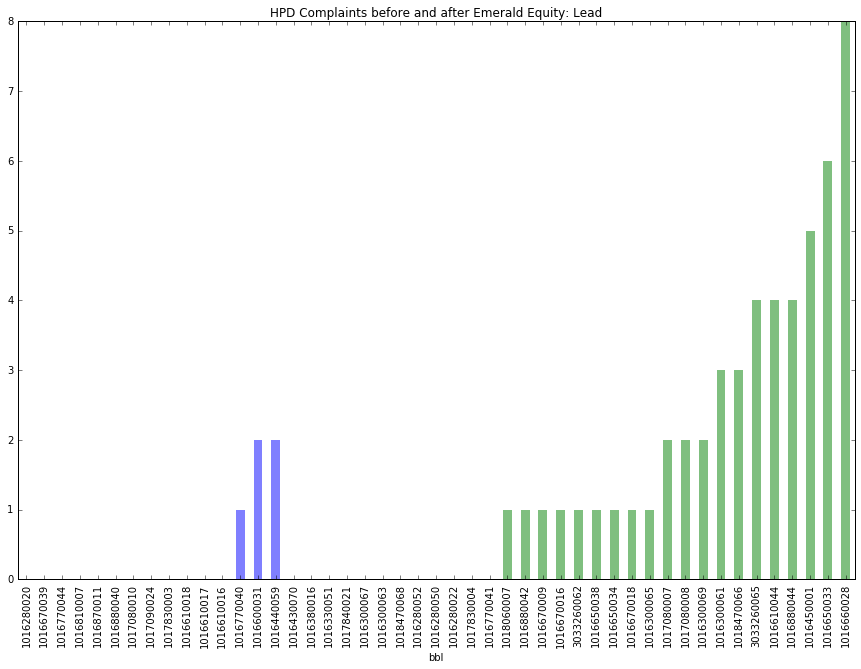

In [385]:
df_hpdnonrecent['Lead'].sort_values(ascending=True).plot(kind='bar', stacked=True, figsize=(15, 10), color = 'blue', alpha=.5, linewidth=0)
df_hpdrecent['Lead'].sort_values(ascending=True).plot(kind='bar', stacked=True, figsize=(15, 10), color = 'green', alpha =.5, linewidth=0)
plt.title("HPD Complaints before and after Emerald Equity: Lead")
plt.savefig('hpd-lead-complaints.png')

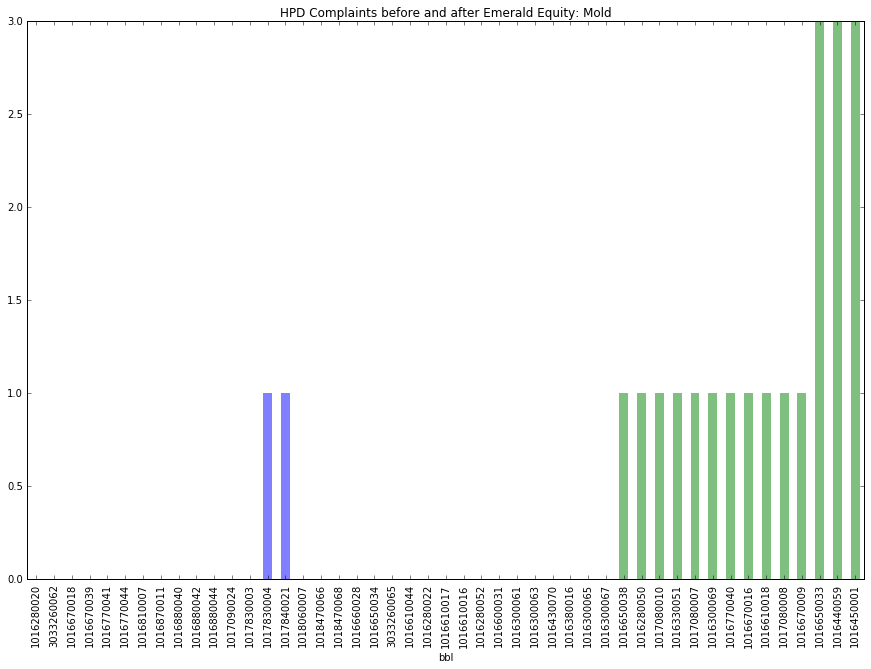

In [386]:
df_hpdnonrecent['Mold'].sort_values(ascending=True).plot(kind='bar', stacked=True, figsize=(15, 10), color = 'blue',linewidth=0, alpha=.5)
df_hpdrecent['Mold'].sort_values(ascending=True).plot(kind='bar', stacked=True, figsize=(15, 10),linewidth=0, color = 'green', alpha =.5)
plt.title("HPD Complaints before and after Emerald Equity: Mold")
plt.savefig('hpd-mold-complaints.png')

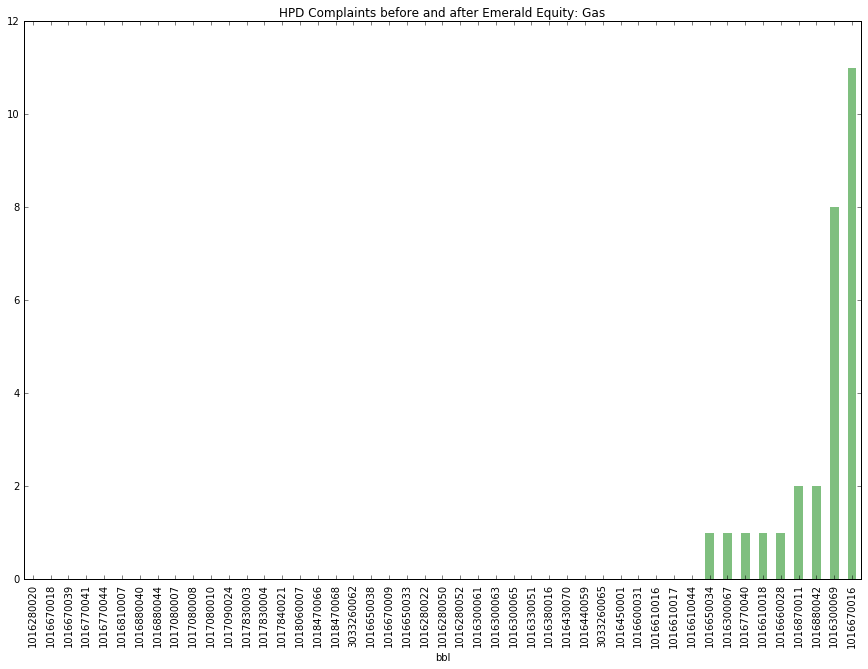

In [387]:
df_hpdnonrecent['Gas'].sort_values(ascending=True).plot(kind='bar', stacked=True, figsize=(15, 10),linewidth=0, color = 'blue', alpha=.5)
df_hpdrecent['Gas'].sort_values(ascending=True).plot(kind='bar', stacked=True, figsize=(15, 10),linewidth=0, color = 'green', alpha =.5)
plt.title("HPD Complaints before and after Emerald Equity: Gas")
plt.savefig('hpd-gas-complaints.png')

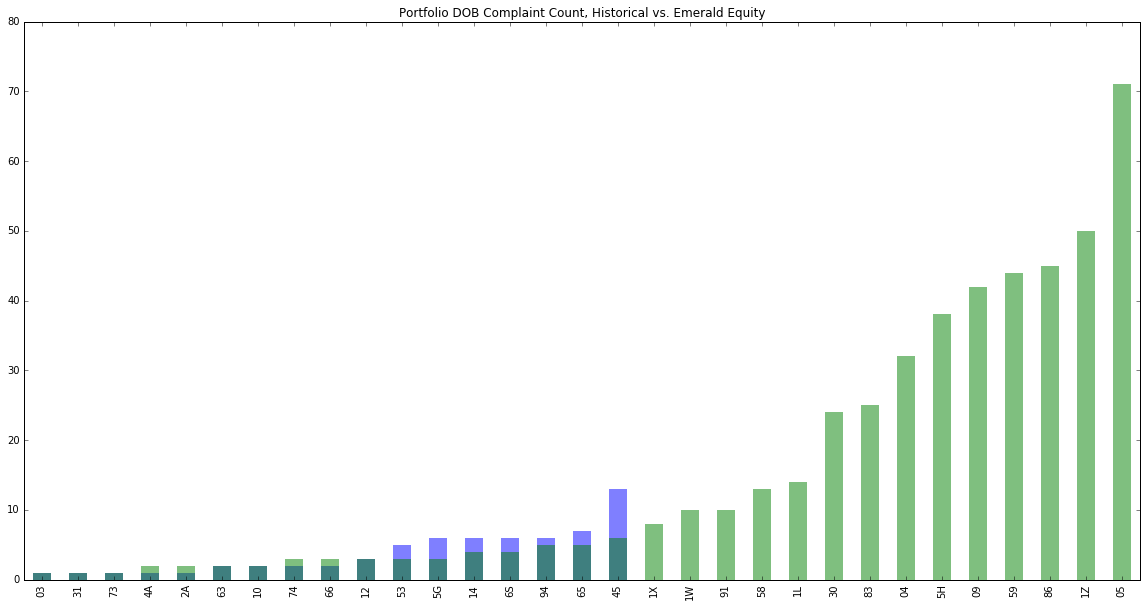

In [388]:
#This data is from 2015-8-30 to 2017-01-01

df_historical['complaintcategory'].value_counts(ascending=True).plot(kind='bar', figsize=(20,10),linewidth=0, alpha=.5, color='blue')

#This data is from 2017-01-01 to 2018-03-11
df_recent['complaintcategory'].value_counts(ascending=True).plot(kind='bar', figsize=(20,10),linewidth=0, color='green',alpha=.5)
plt.title("Portfolio DOB Complaint Count, Historical vs. Emerald Equity")
plt.savefig("dob_complaints.png")



In [389]:
#This is a weird hacky test to highlight a couple values so we can see their particular change over time.
#Change this to colormap later
colors_list=['grey']*2
colors_list.append('darkred')
colors_list.append('darkred')
for color in (range((df_dob['complaintcategory'].nunique())-4)):
    colors_list.append('grey')


In [390]:
df_dob.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_ee = df_dob
df_dob_ee['inspectiondate']= pd.to_datetime(df_dob_ee['inspectiondate'], infer_datetime_format=True, errors='ignore')
df_dob_ee = df_dob.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)

In [391]:
df_dob.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_harlem['inspectiondate'] = pd.to_datetime(df_dob_harlem['inspectiondate'], infer_datetime_format=True, errors='coerce')

In [392]:
df_dob_harlem.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_harlem = df_dob_harlem.set_index(pd.DatetimeIndex(df_dob_harlem['inspectiondate']))
df_dob_harlem = df_dob_harlem.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'inspectiondate' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [393]:
#Sum all of the columns: for this part, we do not care about types of DOB complaints.
df_dob_harlem['summed'] = df_dob_harlem.sum(axis=1)

#sum up the columns for the other DF
df_dob_ee['summed'] = df_dob_ee.sum(axis=1)

In [394]:
#get the per-building number
df_dob_ee['Emerald_Equity']=df_dob_ee['summed']/55
df_dob_harlem['East_Harlem']=df_dob_harlem['summed']/3087

In [395]:
df_dob_harlem.reset_index().set_index('inspectiondate', inplace=True)
df_dob_ee.reset_index().set_index('inspectiondate', inplace=True)

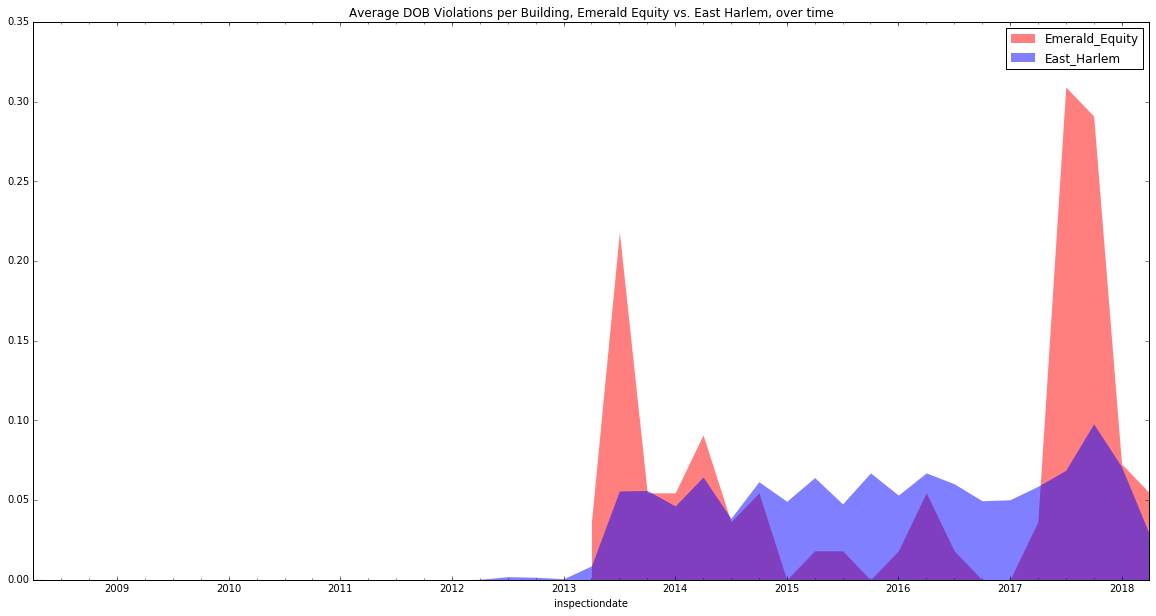

In [398]:
ax = df_dob_ee.resample('3M').sum().plot(kind='area', y='Emerald_Equity', figsize = (20, 10), legend=True, linewidth=0, color='red', alpha=.5)
df_dob_harlem.resample('3M').sum().plot(kind='area', y='East_Harlem', figsize = (20, 10), legend=True, linewidth=0, color='blue', alpha=.5, ax=ax)
plt.savefig("DOB_overtime.png")
plt.title("Average DOB Violations per Building, Emerald Equity vs. East Harlem, over time")

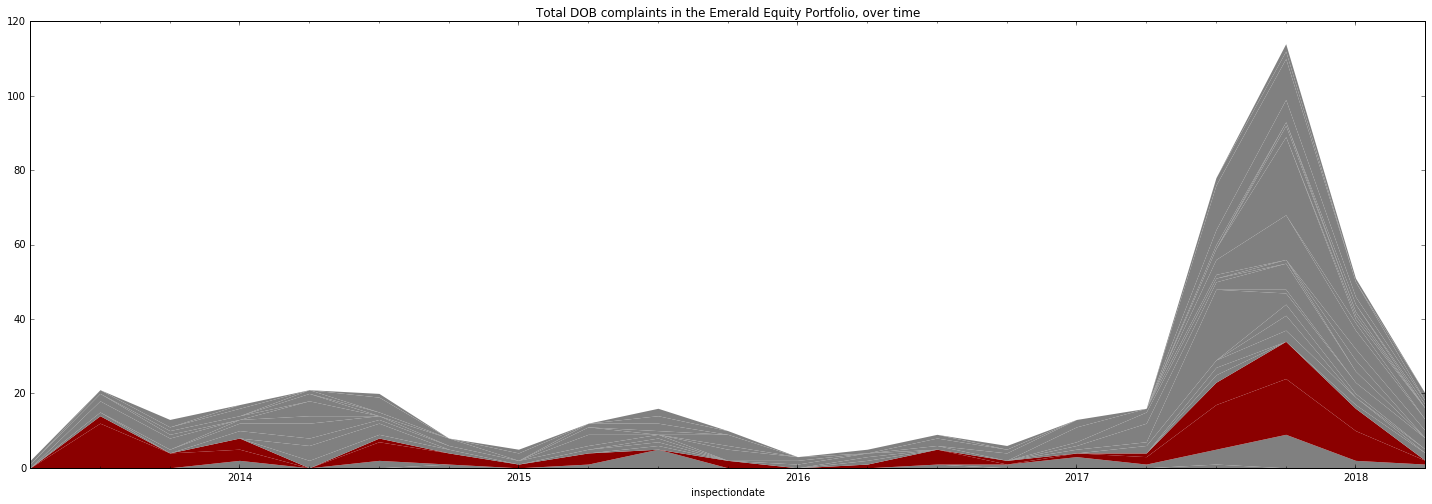

In [324]:
df_dob['inspectiondate']= pd.to_datetime(df_dob['inspectiondate'], infer_datetime_format=True, errors='ignore')
df_dob_zoom = df_dob
df_dob = df_dob.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)
df_dob.resample('3M').sum().plot(kind='area', stacked=True, figsize = (25, 8), legend=False, linewidth=0, color=colors_list)
plt.title("Total DOB complaints in the Emerald Equity Portfolio, over time")
plt.savefig("DOB_overtime.png")


In [325]:
df_dob_zoom = df_dob_zoom[df_dob_zoom['inspectiondate']>purchase]
df_dob_zoom = df_dob_zoom.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)

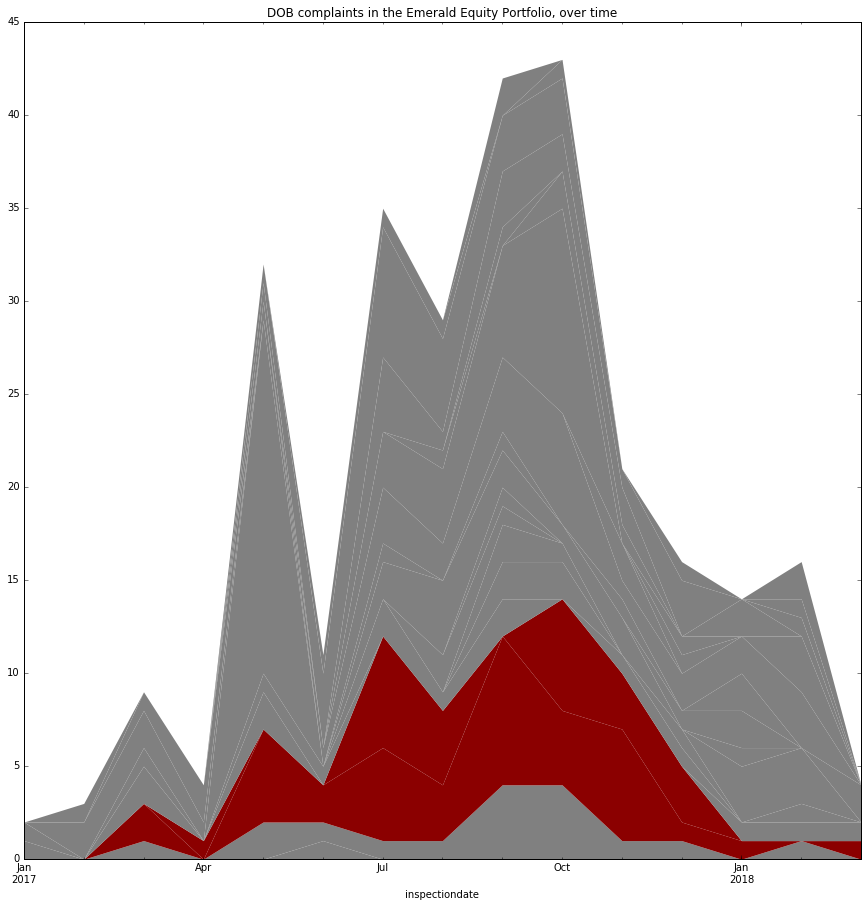

In [326]:
df_dob_zoom.resample('M').sum().plot(kind='area', stacked=True, figsize = (15, 15), legend=False, linewidth=0, color=colors_list)
plt.title("DOB complaints in the Emerald Equity Portfolio, over time")
plt.savefig("DOB_overtime.png")

In [333]:
# Change the date to datetime, and set it as the index
ee_hpd_df['receiveddate']= pd.to_datetime(ee_hpd_df['receiveddate'], infer_datetime_format=True, errors='ignore')
ee_hpd_df.set_index('receiveddate', inplace=True)

In [334]:
# Change the date to datetime, and set it as the index
harlem_hpd_df['receiveddate']= pd.to_datetime(harlem_hpd_df['receiveddate'], infer_datetime_format=True, errors='raise')
harlem_hpd_df.set_index('receiveddate', inplace=True)

#normalize both by total number of buildings in the subset. These are numbers from Pluto_17v1
'''SQL:
SELECT COUNT (DISTINCT bbl) FROM pluto_17v1 WHERE zipcode = '10029' OR zipcode = '10035';
 count 
-------
  3087
(1 row)'''

'''SELECT COUNT (DISTINCT bbl) FROM emerald_equity_bin_bbl;
 count 
-------
    55
(1 row)'''


ee_hpd_df['Emerald_Equity_Count'] = ee_hpd_df['count']/55
harlem_hpd_df['East_Harlem_Count'] = harlem_hpd_df['count']/3087

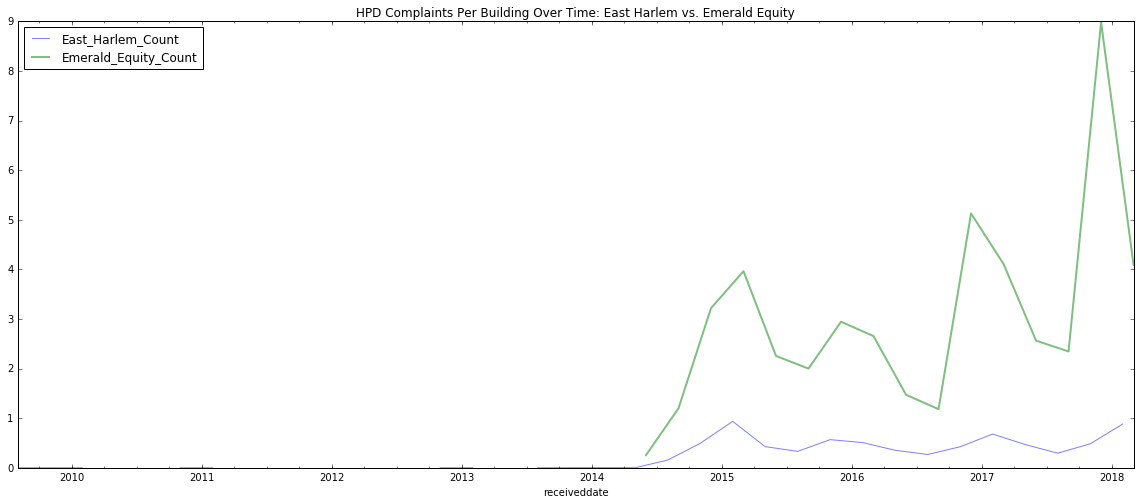

In [335]:
#Drop the original count columns, this looks better for the key
ee_hpd_df.drop('count',axis=1,inplace=True)
harlem_hpd_df.drop('count',axis=1,inplace=True)

#Plot the things
ax = harlem_hpd_df.resample('3M').sum().plot(kind='line', alpha=.5, color='blue')
ee_hpd_df.resample('3M').sum().plot(kind='line', alpha=.5, color='green', figsize =(20,8),linewidth=2, ax=ax)

#Set the title
plt.title("HPD Complaints Per Building Over Time: East Harlem vs. Emerald Equity")